#### This is a Jupyter notebook demonstrating using LongTerm-ShortTerm(LSTM) models to forecast foriegn exchange pair price change

## TODO:
1. Gather data
2. Test for stationarity 
3. Preprocess data to improve stationarity 
4. Retest to prove stationarity 
5. Create input and target arrays for the model
6. Create Model
7. Train model on preprocessed dataset
8. Predict target variable
9. Post process data and display

# Step 1: Gather Data

This step requires an API token for Oanda (a popular forex broker)

In [1]:
# Importing important libraries
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from dotenv import load_dotenv

load_dotenv()

pair = "USD_CAD"
startTimeString = "2022-01-01 00:00:00.000"

# Formatting strings for API call
start = pd.to_datetime(startTimeString).isoformat().replace(":", "%3A").replace(" ","T").split("+00")[0]
newStart = pd.to_datetime(startTimeString) + pd.DateOffset(days=7)
end = newStart.isoformat().replace(":", "%3A").replace(" ","T").split("+00")[0]
now = datetime.datetime.now()

# Continue making requests until the current week
progress = int(float(newStart.strftime('%s.%f')) * 1e3)
stopTime = int(float(now.strftime('%s.%f')) * 1e3)
granularity = "H1" # frequency of candle data (1 candle per hour)

# Creating dataframe to hold candle data
pairCandles = pd.DataFrame()
reqThrottling = 0

api_token = os.getenv("API_TOKEN")
while (progress < stopTime):
    candleData = pd.DataFrame(columns=["Time","Volume","Open","Close","High","Low"])
    # candleData = candleData.reindex(columns=["Time","Volume","Open","Close","High","Low"])
    url = f"https://api-fxtrade.oanda.com/v3/instruments/{pair}/candles?from={start}&to={end}&granularity=H1"
    resetConnection = 0
    response = requests.get(url, headers={"Authorization" : api_token, "Connection": "Keep-Alive"})
    candles = response.json()["candles"]
    for i, candle in enumerate(candles):
        new_row = {"Time":candle["time"],"Volume":float(candles[i]["volume"]),
        "Open":float(candles[i]["mid"]["o"]),"Close":float(candles[i]["mid"]["c"]),"High":float(candles[i]["mid"]["h"]),
        "Low": float(candles[i]["mid"]["l"])}
        candleData.loc[len(candleData)] = new_row
    
    pairCandles = pd.concat([pairCandles, candleData], axis=0)
    
    # Set vars for next API command
    start = newStart.isoformat().replace(":", "%3A").replace(" ","T").split("+00")[0]
    end = (newStart + pd.DateOffset(days=7)).isoformat().replace(":", "%3A").replace(" ","T").split("+00")[0]
    newStart = (newStart + pd.DateOffset(days=7))
    # Increase progress for while loop
    progress = int(float(newStart.strftime('%s.%f')) * 1e3)
    
    # API docs ask for 100 req/second 
    # This sleeps to every 25 req to abide by the limitation
    reqThrottling += 1
    resetConnection +=1
    if reqThrottling > 25:
        time.sleep(.25)
        reqThrottling = 0
    if resetConnection == 1:
        time.sleep(.25)
# write csv file
pairCandles = pairCandles.reset_index(drop=True)
pairCandles.to_csv(f"./TrainingData/{pair}_H1.csv")

In [2]:
# Function to convert my string time to a datetime object
def string_to_datetime(s):
  split = s.split("T")
  time = split[1].split(":")
  year_month_date = split[0].split("-")
  hour, minute = int(time[0]), int(time[1])
  year, month, day = int(year_month_date[0]), int(year_month_date[1]), int(year_month_date[2]) 
  return datetime.datetime(year,month,day,hour,minute)

In [3]:
# To avoid altering the original DF we will save a new dataframe and complete any modifications on the new DF
pairData = pd.DataFrame(pairCandles.copy())

# Take a look at that hard-earned dataset :)
# We just need to replace the "Time" values with actual datetime.datetime objects
# This was we can use the data type as an index. Making this a timeseries
pairData["Time"] = pairData["Time"].apply(string_to_datetime)
pairData.index = pairData.pop("Time")


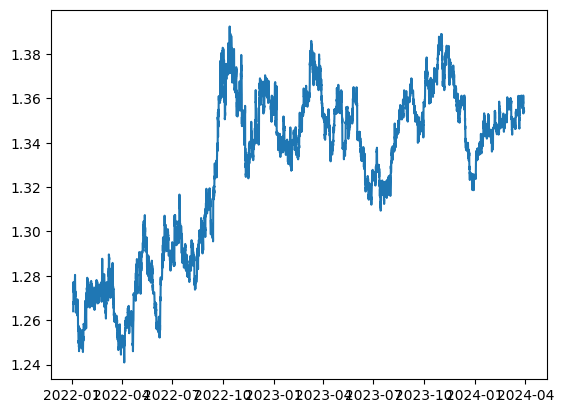

In [4]:
plt.plot(pairData["Close"])
plt.show()


## Step 2: Test for stationarity 

Now that we have our candle stick data we can test the data for stationarity. Machine learning models are better at predicting with stationary datasets.

For a time series to be classified as stationary (covariance stationarity), it must satisfy 3 conditions:

1. Constant mean
2. Constant variance
3. Constant covariance between periods of identical distance
(https://towardsdatascience.com/what-is-stationarity-in-time-series-and-why-should-you-care-f3b45082356b)

We can test for stationarity with the "Augmented Dicky Fuller" test or the ADF. We will use "statsmodels" a popular library in Machine Learning capable of running the test on our dataset

In [5]:
# Turning the dataframe into a numpy array
pairData_np = pairData.values


# getting the count to split the dataset into 3
parts = int(len(pairData_np)/3)
part_1, part_2, part_3 = pairData_np[0:parts], pairData_np[parts:(
    parts*2)], pairData_np[(parts*2):(parts*3)]

print(part_1)


[[5.78000e+02 1.26402e+00 1.26406e+00 1.26455e+00 1.26380e+00]
 [5.77000e+02 1.26412e+00 1.26594e+00 1.26598e+00 1.26314e+00]
 [4.49000e+02 1.26591e+00 1.26538e+00 1.26591e+00 1.26482e+00]
 ...
 [7.21600e+03 1.37084e+00 1.37308e+00 1.37356e+00 1.37045e+00]
 [7.07300e+03 1.37307e+00 1.37130e+00 1.37370e+00 1.37042e+00]
 [9.33300e+03 1.37129e+00 1.36957e+00 1.37144e+00 1.36894e+00]]


OPEN: Augmneted Dickey_fuller Statistic: -7.904703
p-value: 0.000000
Recommended Lags: 42.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567
CLOSE: Augmneted Dickey_fuller Statistic: -2.252701
p-value: 0.187677
Recommended Lags: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567
HIGH: Augmneted Dickey_fuller Statistic: -2.252090
p-value: 0.187886
Recommended Lags: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567
LOW: Augmneted Dickey_fuller Statistic: -2.169931
p-value: 0.217339
Recommended Lags: 10.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


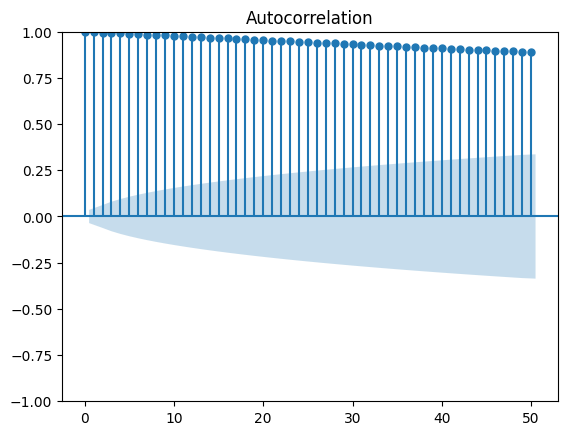

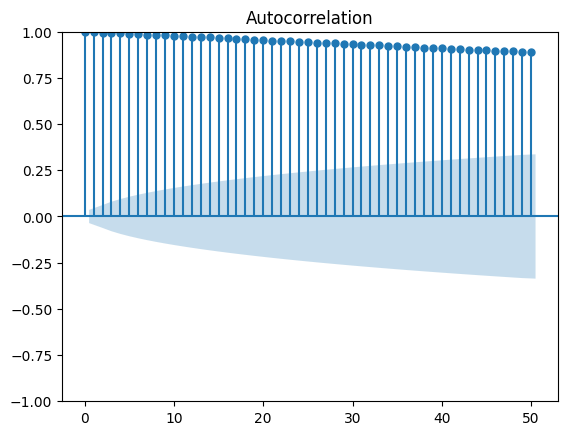

In [6]:
# Import important libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

aD_open = adfuller(pairData_np[:,0])
aD_close = adfuller(pairData_np[:,1])
aD_high = adfuller(pairData_np[:,2])
aD_low = adfuller(pairData_np[:,3])

# Augmneted Dickey_fuller test
# Printing the statistical result of the adfuller test
print('OPEN: Augmneted Dickey_fuller Statistic: %f' % aD_open[0])
print('p-value: %f' % aD_open[1])
print('Recommended Lags: %f' % aD_open[2])

# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in aD_open[4].items():
    print('\t%s: %.3f' % (k, v))
    
print('CLOSE: Augmneted Dickey_fuller Statistic: %f' % aD_close[0])
print('p-value: %f' % aD_close[1])
print('Recommended Lags: %f' % aD_close[2])

# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in aD_close[4].items():
    print('\t%s: %.3f' % (k, v))

print('HIGH: Augmneted Dickey_fuller Statistic: %f' % aD_high[0])
print('p-value: %f' % aD_high[1])
print('Recommended Lags: %f' % aD_high[2])

# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in aD_high[4].items():
    print('\t%s: %.3f' % (k, v))
    

print('LOW: Augmneted Dickey_fuller Statistic: %f' % aD_low[0])
print('p-value: %f' % aD_low[1])
print('Recommended Lags: %f' % aD_low[2])

# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in aD_low[4].items():
    print('\t%s: %.3f' % (k, v))
    
    

# ACF
plot_acf(pairData["Close"].tail(3000), lags=50)
plot_acf(pairData["Open"].tail(3000), lags=50)
plt.show()

From the above outputs the data does not look stationary. We would want the graphs to have a steep dropoff after a few lags. However, the ADF test shows promising results. Given that the "Augmneted Dickey_fuller Statistic" is negative is a great sign. Unfortunately, for all arrays except Open we see that the ADF stat is slightly larger than the value of each confidence level. Also, we see that the p-value for all reading except Open are above 0.05. 

Side note: I believe the open statistics read so well because the previous hours close is almost always the next hours opening. This is not something we would ever want to predict, although we may be very successful given the correlation. We see the p-value there is far below 0, and the ADF stat is more negative than all confidence intervals. Further we see that the acf test plot still shows non-stationarity

https://www.geeksforgeeks.org/how-to-check-if-time-series-data-is-stationary-with-python/

# Step 4: Preprocess and Retest for Stationarity

## Important note

To address the fact that this data is not stationary, we can transform the data using mathematic operations to check if any simple transformations such as taking the square root, log, or difference of the values give a better reading. I tested a few of these transformations and I believe taking the diff() of the dataset produces the most stationary results.
(diff is subtracting the current value from the next value iteratively throughout the entire timeseries)

OPEN: Augmneted Dickey_fuller Statistic: -26.702358
p-value: 0.000000
Recommended Lags: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567
CLOSE: Augmneted Dickey_fuller Statistic: -118.789749
p-value: 0.000000
Recommended Lags: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567
HIGH: Augmneted Dickey_fuller Statistic: -118.684961
p-value: 0.000000
Recommended Lags: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567
LOW: Augmneted Dickey_fuller Statistic: -38.935654
p-value: 0.000000
Recommended Lags: 9.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


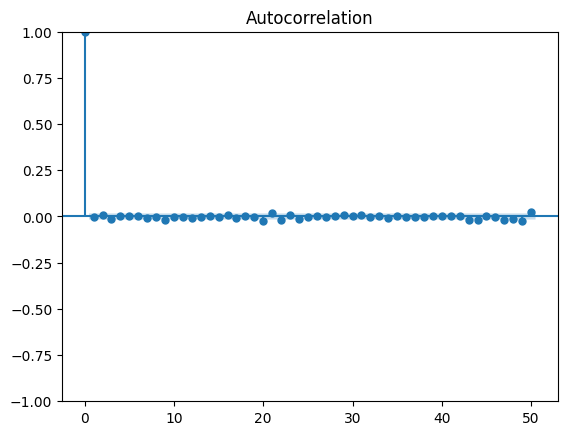

In [7]:
aD_open = adfuller(np.diff(pairData_np[:,0]))
aD_close = adfuller(np.diff(pairData_np[:,1]))
aD_high = adfuller(np.diff(pairData_np[:,2]))
aD_low = adfuller(np.diff(pairData_np[:,3]))

# Printing the statistical result of the adfuller test
print('OPEN: Augmneted Dickey_fuller Statistic: %f' % aD_open[0])
print('p-value: %f' % aD_open[1])
print('Recommended Lags: %f' % aD_close[2])

# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in aD_open[4].items():
    print('\t%s: %.3f' % (k, v))
    
print('CLOSE: Augmneted Dickey_fuller Statistic: %f' % aD_close[0])
print('p-value: %f' % aD_close[1])
print('Recommended Lags: %f' % aD_close[2])

# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in aD_close[4].items():
    print('\t%s: %.3f' % (k, v))

print('HIGH: Augmneted Dickey_fuller Statistic: %f' % aD_high[0])
print('p-value: %f' % aD_high[1])
print('Recommended Lags: %f' % aD_high[2])

# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in aD_high[4].items():
    print('\t%s: %.3f' % (k, v))
    

print('LOW: Augmneted Dickey_fuller Statistic: %f' % aD_low[0])
print('p-value: %f' % aD_low[1])
print('Recommended Lags: %f' % aD_low[2])

# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in aD_low[4].items():
    print('\t%s: %.3f' % (k, v))

# ACF
plot_acf(np.diff(pairData["Close"]), lags=50)
plt.show()

As we can see above 

1. The acf lags take a steep drop off after a single lag.
2. Augmneted Dickey_fuller Statistic is far more negative than any confidence level
3. p-value is zero for all data points

Thus we can "reject the null hypothesis". This data is stationary! 

# Lets take a look at the difference below

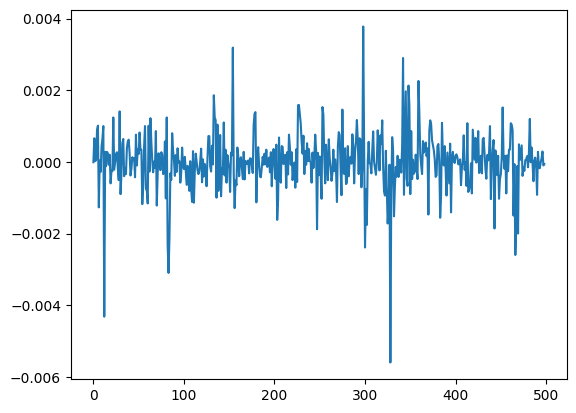

In [8]:
plt.plot(np.diff(pairData["Close"].tail(500)))
plt.show()

In [9]:
# Now that we know how we want to transform the data, we can create a function to do just that
def preprocess(dataframe):
    return_data = pd.DataFrame(columns=["Volume","Open","Close","High","Low"])
    volume = np.diff(dataframe["Volume"]) * 100
    normal_volume = (volume - np.min(volume))/(np.max(volume)-np.min(volume))
    return_data["Volume"] = normal_volume
    return_data["Open"] = np.diff(dataframe["Open"]) * 100
    return_data["Close"] = np.diff(dataframe["Close"]) * 100
    return_data["High"] = np.diff(dataframe["High"]) * 100
    return_data["Low"] = np.diff(dataframe["Low"]) * 100
    return_data.index = dataframe.tail(-1).index
    return return_data


    
    


In [10]:
# Preprocessing the dataframe and saving that as a new processed DF
pairData_prep = preprocess(pairData)
pairData_prep.head()

,Volume,Open,Close,High,Low
Time,,,,,
2022-01-02 23:00:00,0.506524,0.010,0.188,0.143,-0.066
2022-01-03 00:00:00,0.505207,0.179,-0.056,-0.007,0.168
2022-01-03 01:00:00,0.507116,-0.057,0.083,0.055,-0.030
2022-01-03 02:00:00,0.507147,0.085,0.113,0.098,0.162
2022-01-03 03:00:00,0.505010,0.113,0.049,0.114,0.095


# Step 5: Create input and target arrays for the model

To train the model, we will need to create 
1. An input array with each element being a set of data points that we want the model to consider when trying predict the target we call these datapoints "features". For this example, we will create an input array of "lag features" which will be the previous few hours candle data. 
i.e. the "price" at t, t-1, t-2, t-3 will be fed to the AI, we will ask it to predict "price" at time t+1 (with this dataset we would be predicting the price of the next hour, but in some cases you may want to predict price t+4 or four hours into the future.)

2. We will also need to create a "target" array where each element is the actual outcome of what the AI is attempting to predict. This model uses supervised learning, meaning that the AI takes in our input data and also the expected prediction value. For our example I can create the target array by simply shifting the correct column in our df by one. But the target array can be any list of values where the length is the same as the input array

In [11]:
# Import necessary Libraries
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [92]:
#  To visualize input vs. target (w/ 3 lags)


#index # Input Arrays(X) Elements -----------------------------------------------------------> Target Array(y) Elements
# 1    # [[[Open1,Close1,High1,Low1], [Open2,Close2,High2,Low2], [Open3,Close3,High3,Low3]]] [Close4]
# 2    # [[[Open2,Close2,High2,Low2], [Open3,Close3,High3,Low3], [Open4,Close4,High4,Low4]]] [Close5]
# 3    # [[[Open3,Close3,High3,Low3], [Open4,Close4,High4,Low4], [Open5,Close5,High5,Low5]]] [Close6]

def df_to_input_target(df, target_column_index, window_size=48):
    df_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_np)-window_size):
        row = [r for r in df_np[i:i+window_size]]
        X.append(row)
        target_row = df_np[i+window_size][target_column_index]
        y.append(target_row)
    return np.array(X), np.array(y)

# Method to split the data into training test and validation
def train_val_test_split(X, y):
    x_test_split = int(len(X)*0.6)
    x_val_split = int(len(X)*0.85)
    X_train, X_validate, X_test = X[0:x_test_split], X[x_test_split:x_val_split], X[x_val_split:]
    y_train, y_validate, y_test = y[0:x_test_split], y[x_test_split:x_val_split], y[x_val_split:]
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [93]:
X , y = df_to_input_target(pairData_prep, 4) 

# Checking shape
print(X.shape, y.shape)

# Splitting data into test train and validation
X_train, X_validate, X_test, y_train, y_validate, y_test = train_val_test_split(X, y)
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

(13918, 48, 5) (13918,)


((8350, 48, 5), (3480, 48, 5), (2088, 48, 5), (8350,), (3480,), (2088,))

# Step 6: Create the model

This step is pretty simple given that the tensorflow libraries available are capable of creating an LSTM model with few lines of code


In [113]:
# Import required dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint


# Creating the model
# Input((9,5) ---> 9 lags by 5 datapoints(features)
forex_forecasting_model = Sequential([layers.Input((48,5)),layers.LSTM(32, return_sequences=True),
                                        layers.LSTM(32),
                                        layers.Dense(32, activation="tanh"),
                                        layers.Dense(1)])

forex_forecasting_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 32)            4864      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,273
Trainable params: 14,273
Non-trainable params: 0
_________________________________________________________________


In [114]:
# Model checkpoint helps me save progress
save_point = ModelCheckpoint("Forex_LSTM_V9", save_best_only=True)
forex_forecasting_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0002),
              metrics=['mean_absolute_error'])

In [115]:
# fitting the model
# 20 epochs == 20 loops throught timeseries or 20 tries
forex_forecasting_model.fit(X_train,y_train, validation_data=(X_validate,y_validate), epochs=100, callbacks=[save_point])

Epoch 1/100
260/261 [============================>.] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0799

KeyboardInterrupt: 

In [96]:
def postprocess(original_df,preprocessed_input, prediction_array, target_column="Close"):
    df_np = original_df[target_column].to_numpy()
    actual_post = np.r_[df_np[0], preprocessed_input].cumsum()/100
    prediction_post = np.r_[df_np[0], prediction_array].cumsum()/100
    return prediction_post, actual_post

In [108]:
# defining function for ploting predictions
def plot_predictions(model, X, y, target_column="Close", start=0, end=2000):
    predictions = model.predict(X).flatten()
    predictions_post, actuals = postprocess(pairData.tail(len(y_test)),y_test,predictions, "Low")
    print(len(predictions_post), len(actuals))
    df = pd.DataFrame(data = {"Predictions": predictions_post, "Actuals": actuals})
    plt.plot(df["Predictions"][start:end])
    plt.plot(df["Actuals"][start:end])
    return df, mse(y, predictions)

66/66 [==============================] - 2s 25ms/step
2089 2089


(      Predictions   Actuals
 0        0.013615  0.013615
 1        0.013531  0.013785
 2        0.013519  0.012775
 3        0.013233  0.012595
 4        0.013371  0.012425
 ...           ...       ...
 2084     0.198610  0.006385
 2085     0.198448  0.006395
 2086     0.198394  0.006425
 2087     0.198548  0.006635
 2088     0.198494  0.005665
 
 [2089 rows x 2 columns],
 0.004049553595626172)

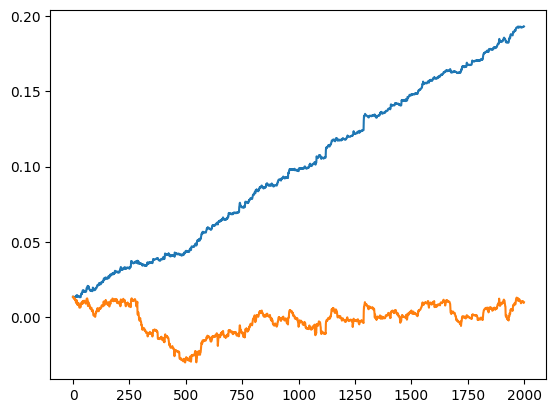

In [109]:
plot_predictions(forex_forecasting_model, X_test, y_test)

Well thats science. As you can see our model is not very good at predicting the price

Things to try:
1. More epochs
2. extract features with tsfresh
3. Test different models (outside of LSTM)

In [122]:
from tsfresh import extract_features
pairData_prep["DateTime"] = pairData_prep.index.name
pairData_prep.index.name = "Time"
pairData_prep.head()
features = extract_features(pairData_prep, column_id="DateTime", column_sort="DateTime",column_value="Low")

ValueError: Column not found: Index

In [112]:
from tensorflow.keras.backend import clear_session

clear_session()